### **Install required libraries**

In [4]:
# Install torch and torchvision (cpu version)
# Run the following code in terminal
'pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cpu'

# Install other libraries for visualization and image processing
'pip3 install opencv-python matplotlib pyyaml requests'

'pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cpu'

### **Object detection and counting**

Using cache found in /home/ubuntu/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-6-11 Python-3.10.12 torch-2.3.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Number of persons: 6
Number of motor vehicles: 14
Number of non-motor vehicles: 0


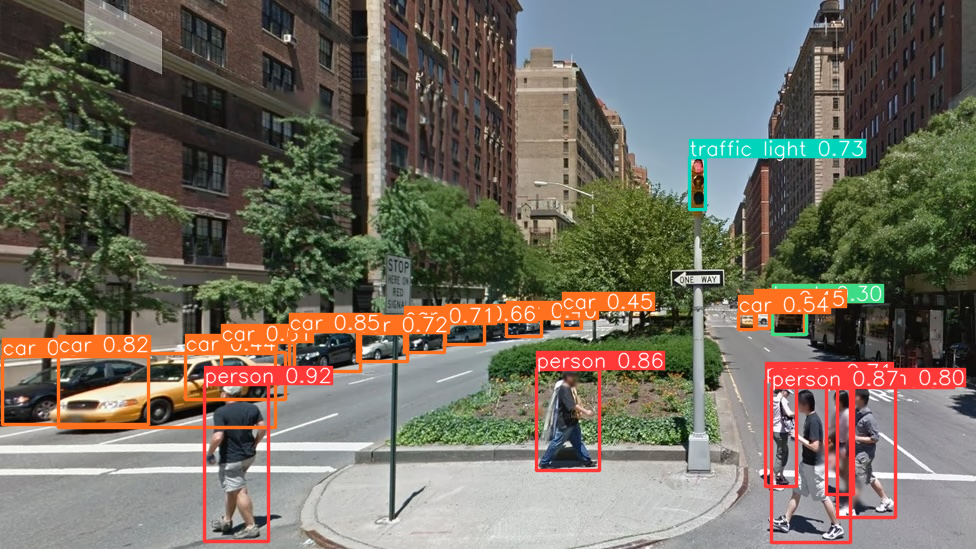

In [9]:
import torch
from matplotlib import pyplot as plt
import cv2

# Load Yolov5 Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Define the path of the test image
img_path = './test.jpeg'  # 替换为你的测试图像路径

# Load the image
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Predict the image
results = model(image_rgb)

# Output Decoding
labels = results.xyxyn[0][:, -1].cpu().numpy()
classes = results.names

# Counting pedestrians, motorized and non-motorized vehicles
person_count = 0
motor_vehicle_count = 0
non_motor_vehicle_count = 0

# Refer to the COCO dataset class index
person_class_index = 0
motor_vehicle_class_indices = [2, 3, 5, 7]  # car, motorcycle, bus, truck
non_motor_vehicle_class_indices = [1]  # bicycle

for label in labels:
    if label == person_class_index:
        person_count += 1
    elif label in motor_vehicle_class_indices:
        motor_vehicle_count += 1
    elif label in non_motor_vehicle_class_indices:
        non_motor_vehicle_count += 1

print(f"Number of persons: {person_count}")
print(f"Number of motor vehicles: {motor_vehicle_count}")
print(f"Number of non-motor vehicles: {non_motor_vehicle_count}")

# Visualization
results.show()


### **Streetscape Indexes Computing**

Sky and Tree Class Proportions in Segmentation:
Sky (Class 2): 0.0999 (24695 pixels)
Tree (Class 4): 0.3029 (74883 pixels)


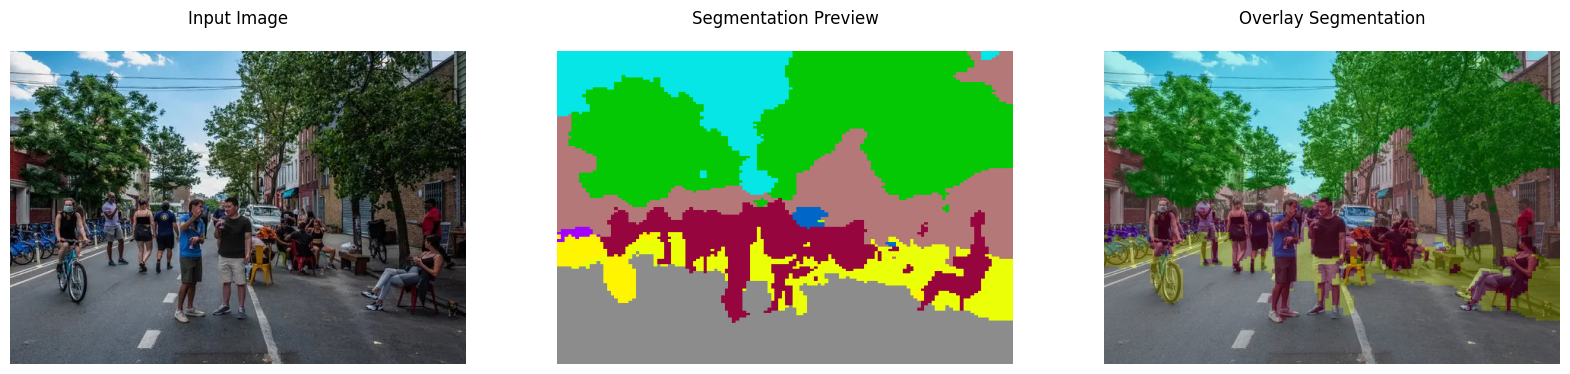

In [2]:
import torch
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import warnings

# Ignore FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load the Segformer model and feature extractor
processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512", do_reduce_labels=True)
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# Transfer the model to CPU
device = torch.device("cpu")
model.to(device)

# Load the image
img_path = './test2.jpeg'  # 替换为你的测试图像路径
image = Image.open(img_path).convert("RGB")
original_size = image.size
inputs = processor(images=image, return_tensors="pt")

# Transfer the inputs to the device
inputs = {k: v.to(device) for k, v in inputs.items()}

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # Shape (batch_size, num_classes, height, width)

# Get the segmentation mask and resize it to the original size
segmentation = torch.argmax(logits, dim=1)[0]  # Shape (height, width)
segmentation = torch.nn.functional.interpolate(
    segmentation.unsqueeze(0).unsqueeze(0).float(),
    size=(original_size[1], original_size[0]),
    mode='nearest'
).squeeze().long()

# Decode the class coding and find the indices of the sky and tree classes
class_coding = pd.read_csv('./ADE20K_Class_Coding.csv')

# Get the class indices for sky and tree
sky_class = class_coding[class_coding['Name'] == 'sky']['Idx'].values[0] - 1
tree_class = class_coding[class_coding['Name'] == 'tree']['Idx'].values[0] - 1

# Format the proportion information
def print_sky_tree_proportions(seg_map, sky_class, tree_class):
    total_pixels = seg_map.size
    
    sky_pixels = np.sum(seg_map == sky_class)
    tree_pixels = np.sum(seg_map == tree_class)
    
    sky_proportion = sky_pixels / total_pixels
    tree_proportion = tree_pixels / total_pixels
    
    print("Sky and Tree Class Proportions in Segmentation:")
    print(f"Sky (Class {sky_class}): {sky_proportion:.4f} ({sky_pixels} pixels)")
    print(f"Tree (Class {tree_class}): {tree_proportion:.4f} ({tree_pixels} pixels)")

# Print the proportions of the sky and tree classes
print_sky_tree_proportions(segmentation.cpu().numpy(), sky_class, tree_class)

# Extract the color coding for each class
color_dict = {}
for _, row in class_coding.iterrows():
    idx = row['Idx'] - 1
    color_str = row['Color_Code (R,G,B)']
    # Remove leading zeros
    color = tuple(int(re.sub(r'^0+', '', c)) if c != '0' else 0 for c in re.findall(r'\d+', color_str))
    color_dict[idx] = color

# Visualization
def visualize_segmentation(image, segmentation, color_dict, alpha=0.3):
    # Create a blank image for the segmentation
    seg_image = np.zeros((segmentation.shape[0], segmentation.shape[1], 3), dtype=np.uint8)

    # Insert the color coding for each class
    for idx, color in color_dict.items():
        seg_image[segmentation == idx] = color

    # Preview the raw image
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Input Image",pad=20)
    plt.axis("off")

    # Preview the segmentation result
    plt.subplot(1, 3, 2)
    plt.imshow(seg_image)  # 不叠加，单独显示分割结果
    plt.title("Segmentation Preview",pad=20)
    plt.axis("off")

    # Preview the overlay of the segmentation result
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(seg_image, alpha=alpha)
    plt.title("Overlay Segmentation",pad=20)
    plt.axis("off")

    plt.show()

visualize_segmentation(image, segmentation.cpu().numpy(), color_dict)